<a href="https://colab.research.google.com/github/parkjlearning/BrainTumorSegmentation/blob/master/U_net_model_BraTS2020_tumor_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Brain tumor segmentation problem definition**

**Segmentation of glioma in pre-operative MRI scans.**  
(*Glioma is a common type of tumor originating in the brain comprising about 33% of all brain tumors.*) 

*Each pixel on image must be labeled:*
* Pixel is part of a tumor area (1 or 2 or 3), and can be one of multiple classes / sug-regions. 
* If a pixel is not on a tumor region (0). 
* The subregions of tumor considered for evaluation are: 1) the "enhancing tumor" (ET), 2) the "tumor core" (TC), and 3) the "whole tumor" (WT).  
* The provided segmentation labels have values of 1 for NCR & NET, 2 for ED, 4 for ET, and 0 for everything else. 


![picture](https://drive.google.com/uc?export=view&id=1x6CicgeqjxJy64gQRXWWKTw-F6V-GP4p)

## **2. Import libraries**

In [1]:
# Mount the drive
from google.colab import drive 
drive.mount('/content/drive')
# Define paths to data
train_path = '/content/drive/My Drive/Colab_data/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
val_path   = '/content/drive/My Drive/Colab_data/BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

Mounted at /content/drive


In [2]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  
import pickle
from pathlib import Path
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

In [ ]:
# neural imaging
!pip install nilearn
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
import gif_your_nifti.core as gif2nif

In [4]:
# ML libraries
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import Input
from tensorflow.keras.models import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

## **3. Image data description**

All BraTS multimodal scans are available as NIfTI files (.nii.gz) → commonly used medical imaging format to store brain image data obtained using MRI and describe different MRI settings. 


1. **T1**: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
2. **T1c**: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
3. **T2**: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
4. **FLAIR**: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2-6 mm slice thickness. 

Data were acquired with different clinical protocols and various scanners from multiple (n=19) institutions.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.

In [86]:
# Define seg-areas
segment_classes = {
    0 : 'NOT tumor', 
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA', # swelling
    3 : 'ENHANCING' # originally 4 (converted into 3 later)
}

# There are 155 slices per volume
# to start at 5 and use 145 slices means that we will skip the first 5 and last 5
volume_slices = 100 # the number of slices to be used
volume_start_at = 22 # the first slice of volume to be used

{0: 'NOT tumor', 1: 'NECROTIC/CORE', 2: 'EDEMA', 3: 'ENHANCING'}

## **4. Build model (U-Net architecture)**
### 4-1. Define model evaluation metrics (loss) 
A metric ***'dice coefficient'*** is essentially the overlap between two samples. This measure ranges from 0 to 1, where 1 or 0 denotes a perfect or no overlap, respectively. The denominator subserves normalization relative to the size of the target mask such that the soft dice loss can learn equally well from the classes with lesser spatial representation in an image.
![picture](https://drive.google.com/uc?export=view&id=1x91FNRszWmXszwJ_ZZ2J5cR-W37EQNBy)
***image credit:*** [Jeremy Jordan](https://www.jeremyjordan.me/semantic-segmentation/)


In [7]:
# dice coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    classes = 4
    for i in range(classes):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

        if i == 0: 
            total_loss = loss 
        else:
            total_loss = total_loss + loss

    total_loss = total_loss / classes
    return total_loss 

In [8]:
# define dice coefficient per class for class-specific evaluation (necrotic)
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6): 
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    loss_necrotic = (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)
    return loss_necrotic

In [9]:
# define dice coefficient per class for class-specific evaluation (edema)
def dice_coef_edema(y_true, y_pred, epsilon=1e-6): 
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    loss_edema = (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)
    return loss_edema

In [10]:
# define dice coefficient per class for class-specific evaluation (enhancing)
def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6): 
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    loss_enhancing = (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)
    return loss_enhancing

In [11]:
# computing precision
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon()) 

In [12]:
# computing sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon()) 

In [13]:
# computing specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon()) 

### 4-2. U-Net architecture
![picture](https://drive.google.com/uc?export=view&id=1wKibS4cJAaOo77UmG4vC3yVwtpy4R8eC) 

source 1. [Naomi Fridman](https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a)  
source 2. [Rastislav Kopal](https://www.kaggle.com/rastislav/3d-mri-brain-tumor-segmentation-u-net)

In [14]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([conv4,up6], axis=3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis=3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis=3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis=3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    conv10 = Conv2D(4, (1,1), activation='softmax')(conv9)

    return Model(inputs=inputs, outputs=conv10)

In [15]:
IMG_SIZE = 128

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy', 
                       tf.keras.metrics.MeanIoU(num_classes=4), 
                       dice_coef, 
                       precision, 
                       sensitivity, 
                       specificity, 
                       dice_coef_necrotic, 
                       dice_coef_edema, 
                       dice_coef_enhancing])

### 4-3. Plot U-Net architecture

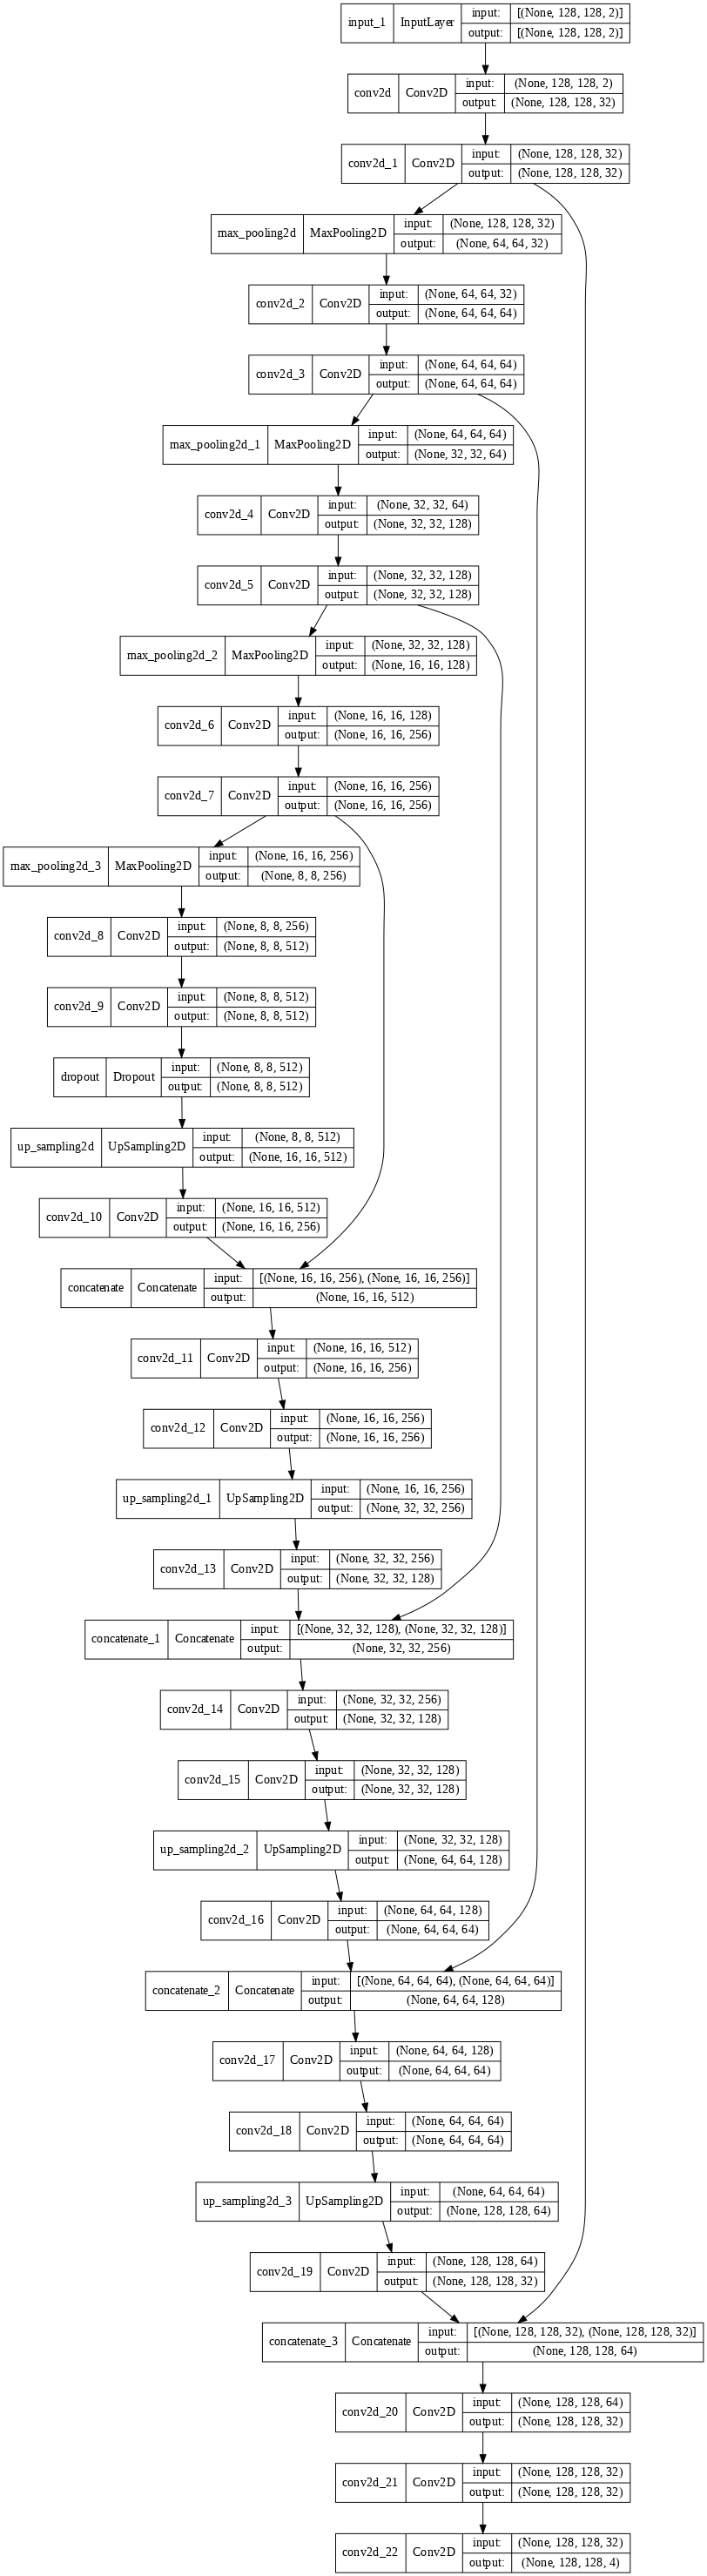

In [ ]:
plot_model(model, 
           show_shapes=True, 
           show_dtype=False,
           show_layer_names=True,
           rankdir='TB', 
           expand_nested=False, 
           dpi=70, 
           to_file="/content/drive/My Drive/Colab_data/BraTS2020/model_u_net1.png"
           )

## **4. Train the model**
### 4-1. Load data and get train, validation, test splits

In [16]:
# list directories
train_and_val_dir = [f.path for f in os.scandir(train_path) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for seg.nii file
train_and_val_dir.remove(train_path + '/BraTS20_Training_355')

# get file names from paths
def path_list_into_ids(dir_list): 
    x = []
    for i in range(len(dir_list)):
        x.append(dir_list[i][dir_list[i].rfind('/')+1:])
    return x

train_and_test_ids = path_list_into_ids(train_and_val_dir)

# get train, validation, and test sets
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

### 4-2. Create DataGenerator class
Loading all data into memory is not a good idea as the data are too big to fit in. Thus, we will create a class DataGenerator overriding 'tf.keras.utils.Sequence', which will be used for real-time data feeding to the U-Net model. 

In [89]:
class DataGenerator(tf.keras.utils.Sequence):
    # Generates data for Keras
    
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size=5, n_channels=2, shuffle=True): 
        # Initialization
        self.list_IDs = list_IDs
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self): 
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size] # self.indexes = np.arange(len(self.list_IDs)) @on_epoch_end

        # Find list of IDs
        batch_IDs = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(batch_IDs)

        return X, y

    def on_epoch_end(self): 
        """
        'on_epoch_end' is triggered once at the very beginning and at the very end of each epoch. 
        If the shuffle parameter is set to True, we will get a new order of exploration at each pass
        (or just keep a linear exploration scheme otherwise). Shuffling the order in which examples are
        fed to the classifier is helpful for differentiating batches between epochs. Doing so will eventually
        make our model more robust
        """
        # Update indexes after each epoch
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True: 
            np.random.shuffle(self.indexes) 

    def __data_generation(self, batch_IDs): 
        # This is the crucial part that produces batches of data - X: (n_samples, *dim (IMG_SIZE,IMG_SIZE), n_channels)
        # Initialization 
        X = np.zeros((self.batch_size * volume_slices, *self.dim, self.n_channels)) # volume_slices=100, '*self.dim': an asterisk was used to unpack all elements in the tuple
        y = np.zeros((self.batch_size * volume_slices, 240, 240)) # the dimension of segmented images should be 240 x 240, note the dimesion of the 3d volumes (240, 240, 155)
        Y = np.zeros((self.batch_size * volume_slices, *self.dim, 4))

        # Generate data 
        for id_i, id in enumerate(batch_IDs): 
            case_path = os.path.join(train_path, id)
            
            # T2-weighted FLAIR image
            flair_path = os.path.join(case_path, f'{id}_flair.nii') 
            flair = nib.load(flair_path).get_fdata()

            # T1-weighted, contrast-enhanced (Gadolinium) image
            ce_path = os.path.join(case_path, f'{id}_t1ce.nii')
            ce = nib.load(ce_path).get_fdata()

            # Manually-segmented image (mask)
            seg_path = os.path.join(case_path, f'{id}_seg.nii') 
            seg = nib.load(seg_path).get_fdata()

            for slice_i in range(volume_slices):
                # X comprises two channels - flair and ce  
                X[slice_i + volume_slices*id_i,:,:,0] = cv2.resize(flair[:,:,slice_i+volume_start_at], (IMG_SIZE, IMG_SIZE)) # Use OpenCV cv2 module to resize the 240x240 images to 128x128
                X[slice_i + volume_slices*id_i,:,:,1] = cv2.resize(ce[:,:,slice_i+volume_start_at], (IMG_SIZE, IMG_SIZE))
                # Target is the manually-segmented images
                y[slice_i + volume_slices*id_i] = seg[:,:,slice_i+volume_start_at]
        
        # Generate masks
        y[y==4] = 3; # 'ENHANCING' original 4 -> convert to 3
        mask = tf.one_hot(y, 4) # one-hot encoding of the four classes
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE)) # 240^2 to 128^2
        
        return X/np.max(X), Y

100

In [18]:
train_generator = DataGenerator(train_ids, batch_size=1) 
validation_generator = DataGenerator(val_ids, batch_size=1)
test_generator = DataGenerator(test_ids)

### 4-3. Display the number of data in train/validation/test sets


No handles with labels found to put in legend.


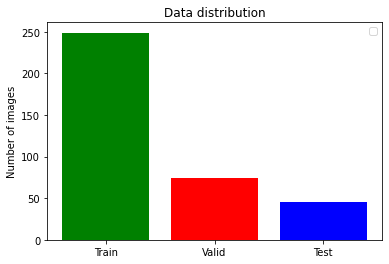

In [ ]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

### 4-4. Add callback for training process
* keras.callbacks.ReduceLROnPlateau 
    * It reduces the learning rate when a metric has stopped improving.
    * Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
    * This callback monitors a quantity (e.g. loss) and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.  
* CSVLogger
    * It saves the training log as a csv file. 


In [19]:
csv_logger = CSVLogger('/content/drive/My Drive/Colab_data/BraTS2020/training.log', separator=',', append=False) # Callback that streams epoch results to a CSV file
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                               patience=2, min_lr=0.000001, verbose=1), 
             csv_logger]

### 4-5. Fit and save the model

In [ ]:
K.clear_session()

history = model.fit(train_generator, 
                    epochs=50,
                    steps_per_epoch=len(train_ids), 
                    callbacks=callbacks, 
                    validation_data=validation_generator 
                    )  

# save the model
model.save("/content/drive/My Drive/Colab_data/BraTS2020/model_u_net1.h5")

# save the training log (history)
with open("/content/drive/My Drive/Colab_data/BraTS2020/model_u_net1_training_log.pickle", 'wb') as f: 
    pickle.dump(history, f)


### 4-6. Visualize the training process


In [20]:
# load the trained model
model = keras.models.load_model('/content/drive/My Drive/Colab_data/BraTS2020/model_u_net1.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

df_log = pd.read_csv('/content/drive/My Drive/Colab_data/BraTS2020/training.log', sep=',', engine='python')

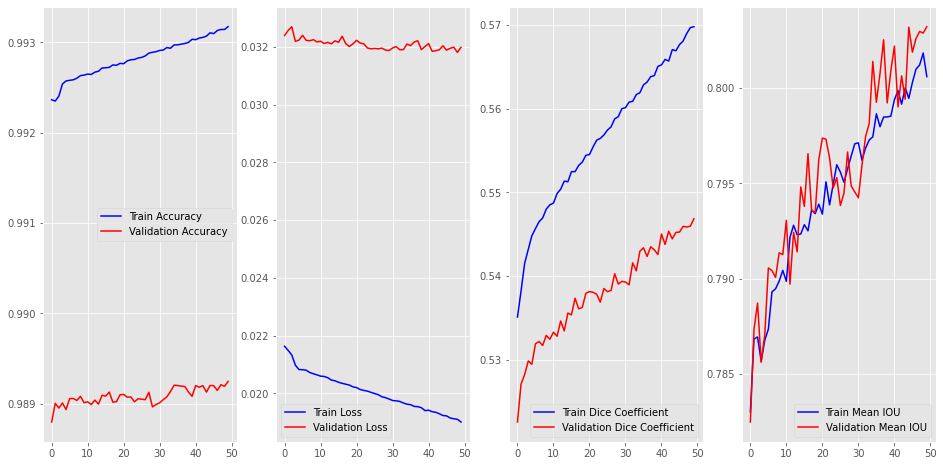

In [21]:
# Visualize training data
fig, ax = plt.subplots(1, 4, figsize=(16,8))
ax[0].plot(df_log.epoch, df_log.accuracy, 'b', label='Train Accuracy')
ax[0].plot(df_log.epoch, df_log.val_accuracy, 'r', label='Validation Accuracy')
ax[0].legend()

ax[1].plot(df_log.epoch, df_log.loss, 'b', label='Train Loss')
ax[1].plot(df_log.epoch, df_log.val_loss, 'r', label='Validation Loss')
ax[1].legend()

ax[2].plot(df_log.epoch, df_log.dice_coef, 'b', label='Train Dice Coefficient')
ax[2].plot(df_log.epoch, df_log.val_dice_coef, 'r', label='Validation Dice Coefficient')
ax[2].legend()

ax[3].plot(df_log.epoch, df_log.mean_io_u, 'b', label='Train Mean IOU')
ax[3].plot(df_log.epoch, df_log.val_mean_io_u, 'r', label='Validation Mean IOU')
ax[3].legend()

plt.show()

## **5. Model evaluation**
### 5-1. Prediction examples

4/4 [==============================] - 16s 3s/step


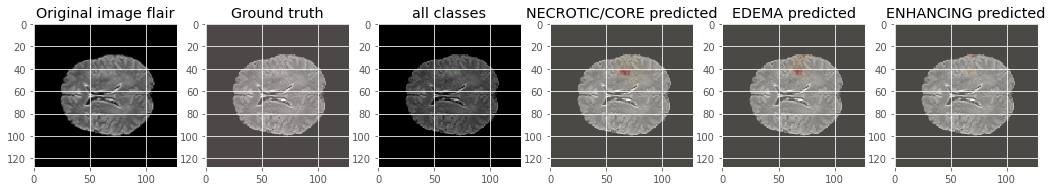

4/4 [==============================] - 19s 4s/step


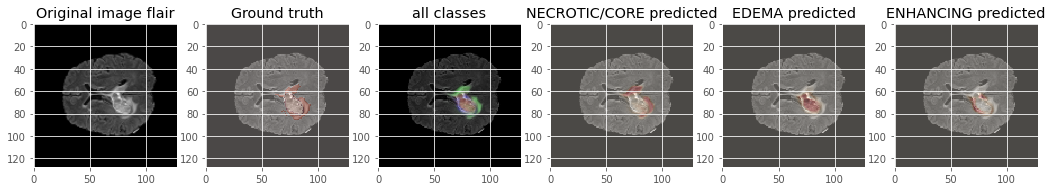

4/4 [==============================] - 13s 3s/step


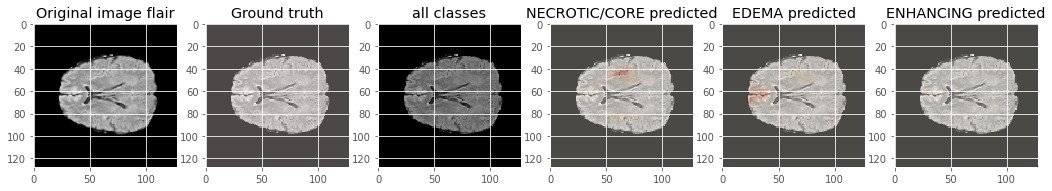

4/4 [==============================] - 13s 3s/step


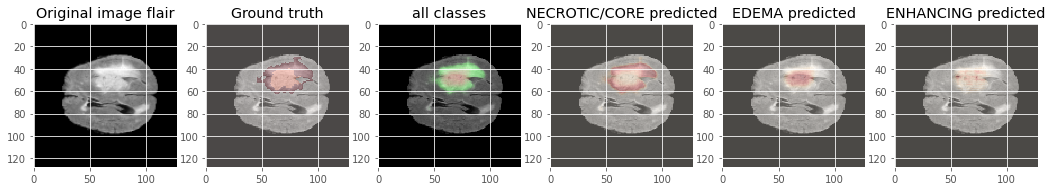

4/4 [==============================] - 13s 3s/step


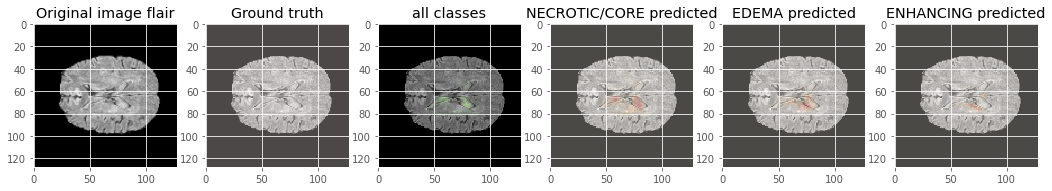

4/4 [==============================] - 13s 3s/step


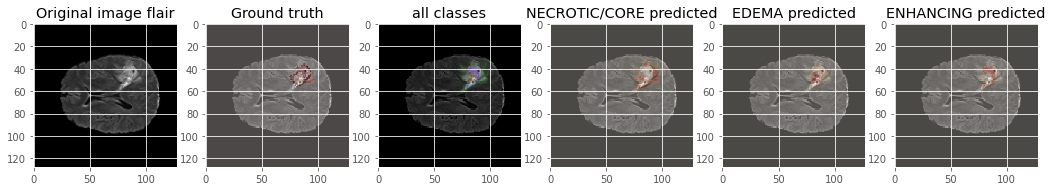

4/4 [==============================] - 13s 3s/step


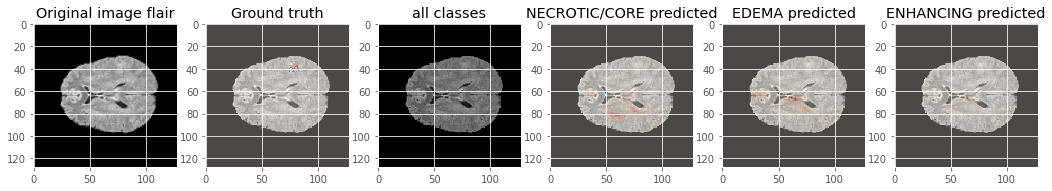

In [93]:
def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2] # The next() function returns the next item in an iterator
    X = np.empty((volume_slices, IMG_SIZE, IMG_SIZE, 2)) # (slice, horizontal_pixels, vertical_pixels, channel)

    flair_path = os.path.join(case_path, f"BraTS20_Training_{case}_flair.nii") 
    flair = nib.load(flair_path).get_fdata()

    t1ce_path = os.path.join(case_path, f"BraTS20_Training_{case}_t1ce.nii")
    ce = nib.load(t1ce_path).get_fdata()

    for j in range(volume_slices): 
        X[j,:,:,0] = cv2.resize(flair[:,:,j+volume_start_at], (IMG_SIZE, IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+volume_start_at], (IMG_SIZE, IMG_SIZE))
    
    return model.predict(X/np.max(X), verbose=1) 

def showPredictionById(case, start_slice=60): 
    path = f"/content/drive/My Drive/Colab_data/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    mask = nib.load(os.path.join(path, f"BraTS20_Training_{case}_seg.nii")).get_fdata() # label
    flair = nib.load(os.path.join(path, f"BraTS20_Training_{case}_flair.nii")).get_fdata() # original image
    p = predictByPath(path, case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    f, ax = plt.subplots(1,6, figsize = (18, 50))
    
    for i in range(6): 
        ax[i].imshow(cv2.resize(flair[:,:,start_slice+volume_start_at], (IMG_SIZE, IMG_SIZE)), cmap='gray', interpolation='none') # original flair image
    
    ax[0].imshow(cv2.resize(flair[:,:,start_slice+volume_start_at], (IMG_SIZE, IMG_SIZE)), cmap='gray')
    ax[0].title.set_text('Original image flair')
    
    curr_mask = cv2.resize(mask[:,:,start_slice+volume_start_at], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    ax[1].imshow(curr_mask, cmap="Reds", interpolation='none', alpha=0.3)
    ax[1].title.set_text('Ground truth')

    ax[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    ax[2].title.set_text('all classes')

    ax[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    ax[3].title.set_text(f'{segment_classes[1]} predicted')
    
    ax[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    ax[4].title.set_text(f'{segment_classes[2]} predicted')
    
    ax[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    ax[5].title.set_text(f'{segment_classes[3]} predicted')
    plt.show()

showPredictionById(case=test_ids[0][-3:])
showPredictionById(case=test_ids[1][-3:])
showPredictionById(case=test_ids[2][-3:])
showPredictionById(case=test_ids[3][-3:])
showPredictionById(case=test_ids[4][-3:])
showPredictionById(case=test_ids[5][-3:])
showPredictionById(case=test_ids[6][-3:])

###***References***:
https://www.med.upenn.edu/cbica/brats2020/tasks.html   
https://www.kaggle.com/rastislav/3d-mri-brain-tumor-segmentation-u-net  
https://github.com/rastislavkopal/3D_BRAIN_TUMOR_SEGMENTATION   
https://www.kaggle.com/rastislav/mri-brain-tumor-survival-prediction   
https://ieeexplore.ieee.org/abstract/document/8736616 (Unet++)   
https://neptune.ai/blog/image-segmentation-tips-and-tricks-from-kaggle-competitions (Image segmentation tricks)  
https://github.com/MichalHek/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization  
https://pypi.org/project/keras-unet-collection/ (keras-unet-collection library 0.1.11)   
https://www.jeremyjordan.me/semantic-segmentation/ (semantic image segmentation)


In [ ]:
df_log.head()

,epoch,accuracy,dice_coef,dice_coef_edema,dice_coef_enhancing,dice_coef_necrotic,loss,lr,mean_io_u,precision,sensitivity,specificity,val_accuracy,val_dice_coef,val_dice_coef_edema,val_dice_coef_enhancing,val_dice_coef_necrotic,val_loss,val_mean_io_u,val_precision,val_sensitivity,val_specificity
0,0,0.992364,0.535091,0.682294,0.611313,0.432736,0.021630,0.000004,0.783016,0.994248,0.989644,0.998003,0.988798,0.522559,0.665223,0.561438,0.421325,0.032395,0.782487,0.992062,0.985230,0.997267
1,1,0.992350,0.538213,0.686311,0.610266,0.435478,0.021485,0.000004,0.786844,0.994129,0.989739,0.997969,0.989005,0.527096,0.669608,0.551797,0.410757,0.032571,0.787333,0.991723,0.985894,0.997165
2,2,0.992405,0.541510,0.690060,0.615894,0.438853,0.021329,0.000004,0.786949,0.994112,0.989882,0.997969,0.988952,0.528232,0.657514,0.555665,0.416583,0.032702,0.788727,0.991738,0.985881,0.997171
3,3,0.992539,0.543170,0.688128,0.616142,0.449849,0.020975,0.000001,0.785681,0.994257,0.989969,0.998012,0.989008,0.529853,0.671524,0.560012,0.420032,0.032195,0.785622,0.991758,0.985883,0.997178
4,4,0.992573,0.544800,0.693552,0.618418,0.446826,0.020824,0.000001,0.786775,0.994236,0.990067,0.998007,0.988935,0.529450,0.665091,0.564573,0.424607,0.032237,0.787055,0.991886,0.985707,0.997218
